<h2>Import Libraries</h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import ensemble
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

<h2>Import Data</h2>

In [2]:
df = pd.read_parquet('data/cleaned_data.parquet')
df.head()

,DATE,TMP,WND_DIR,WND_SPEED,RH,COMED_MW,YEAR,GDP,POPULATION,DATE_CENTRAL,...,WINTER,epoch,IS_HOLIDAY,NEAR_HOLIDAY,HOLIDAY_WEEKEND,IS_DAYTIME,DAWN,DUSK,MIN_TEMP,MAX_TEMP
0,2017-01-01 01:00:00+00:00,28.04,260,6.93439,71.273049,11587.0,2017,8833000,24536000,2016-12-31 19:00:00-06:00,...,True,1.483232e+09,False,False,True,False,False,False,24.98,39.92
1,2017-01-01 02:00:00+00:00,26.96,260,4.69749,71.701603,11549.0,2017,8833000,24536000,2016-12-31 20:00:00-06:00,...,True,1.483236e+09,False,False,True,False,False,False,24.98,39.92
2,2017-01-01 03:00:00+00:00,26.06,250,5.81594,74.418167,11273.0,2017,8833000,24536000,2016-12-31 21:00:00-06:00,...,True,1.483240e+09,False,False,True,False,False,False,24.98,39.92
3,2017-01-01 04:00:00+00:00,26.06,240,6.93439,77.333391,11085.0,2017,8833000,24536000,2016-12-31 22:00:00-06:00,...,True,1.483243e+09,False,False,True,False,False,False,24.98,39.92
4,2017-01-01 05:00:00+00:00,24.98,250,6.93439,80.879103,10801.0,2017,8833000,24536000,2016-12-31 23:00:00-06:00,...,True,1.483247e+09,False,False,True,False,False,False,24.98,39.92


<h2>Split and Scale Data</h2>

In [3]:
# split into datasets
X = df.drop(columns=['DATE', 'DATE_CENTRAL', 'SEASON', 'COMED_MW'])
y = df['COMED_MW']

In [4]:
# split into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [5]:
# scale
sc = preprocessing.StandardScaler()
sc.fit(X_train)
X_train_sc = sc.transform(X_train)
X_train_sc = pd.DataFrame(X_train_sc, columns=X_train.columns)

X_test_sc = sc.transform(X_test)
X_test_sc = pd.DataFrame(X_test_sc, columns=X_test.columns)

<h2>Regression Model 1: Linear</h2>

In [6]:
linreg = LinearRegression(fit_intercept=True)
linreg.fit(X_train_sc, y_train)
linreg_pred = linreg.predict(X_test_sc)

print ('Linear Regression R Sq. Score ---------')
print ('')
print (linreg.score(X=X_test_sc, y=y_test))
print('')
print ('---------------------------')

Linear Regression R Sq. Score ---------

0.5774721326093878

---------------------------


Text(0.5, 1.0, 'Linear Regression - Residuals vs Predicted')

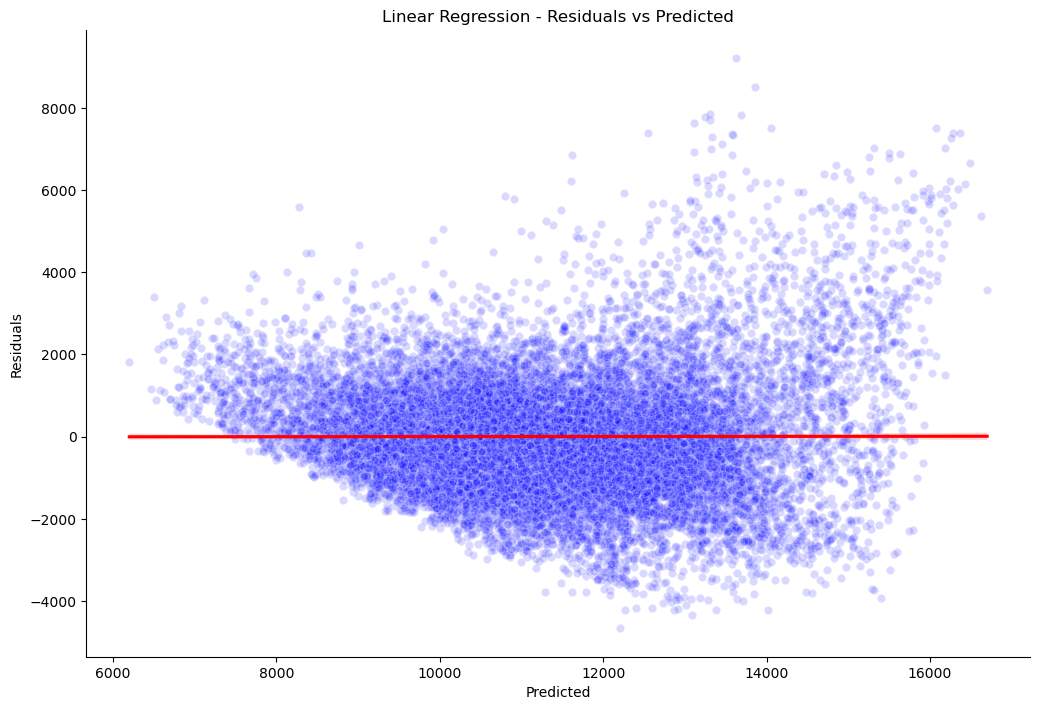

In [7]:
df_linear_results = pd.DataFrame({'Actual': y_test, 'Predicted': linreg_pred})
df_linear_results['Residuals'] = df_linear_results['Actual'] - df_linear_results['Predicted']

sns.lmplot(x='Predicted', y='Residuals', data=df_linear_results, height=7,
          aspect=1.5, scatter_kws={'alpha': 0.15, 'color': 'blue', 'edgecolor': 'white'},
          line_kws={'color': 'red'})
plt.title('Linear Regression - Residuals vs Predicted')

<h2>Regression Model 2: Gradient Boosting</h2>

In [8]:
gbr_reg = ensemble.GradientBoostingRegressor()
gbr_reg.fit(X_train_sc, y_train)

gbr_pred = gbr_reg.predict(X_test_sc)

print('R2:', r2_score(y_test, gbr_pred))
print('Mean Absolute Error:', mean_absolute_error(y_test, gbr_pred))
print('Mean Squared Error:', mean_squared_error(y_test, gbr_pred))

R2: 0.9466388238539158
Mean Absolute Error: 390.51975887065095
Mean Squared Error: 282233.98186926136


In [9]:
# optimize hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'random_state': [42]
}

gbr_cv = GridSearchCV(gbr_reg, param_grid, cv=3, n_jobs=-1) 
gbr_cv.fit(X_train_sc, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [100, 200, 300],
                         'random_state': [42]})

In [10]:
gbr_cv.best_params_

{'learning_rate': 0.2,
 'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300,
 'random_state': 42}

In [11]:
gbr_cv_pred = gbr_cv.predict(X_test_sc)
print('R2:', r2_score(y_test, gbr_cv_pred))
print('Mean Absolute Error:', mean_absolute_error(y_test, gbr_cv_pred))
print('Mean Squared Error:', mean_squared_error(y_test, gbr_cv_pred))

R2: 0.9849754315400804
Mean Absolute Error: 196.8731475654078
Mean Squared Error: 79466.83503942247


In [12]:
# top 5 most important features
gbr_final = ensemble.GradientBoostingRegressor(**gbr_cv.best_params_)
gbr_final.fit(X_train_sc, y_train)

for importance, name in sorted(zip(gbr_final.feature_importances_, X_train.columns), reverse=True)[:5]:
    print(name, importance)

TMP 0.5098389413657055
HOUR 0.20477039856084955
MIN_TEMP 0.08597264277820822
IS_WEEKEND 0.07891812242292773
MAX_TEMP 0.04037590626103848


Text(0.5, 1.0, 'Top 10 Most Important Features')

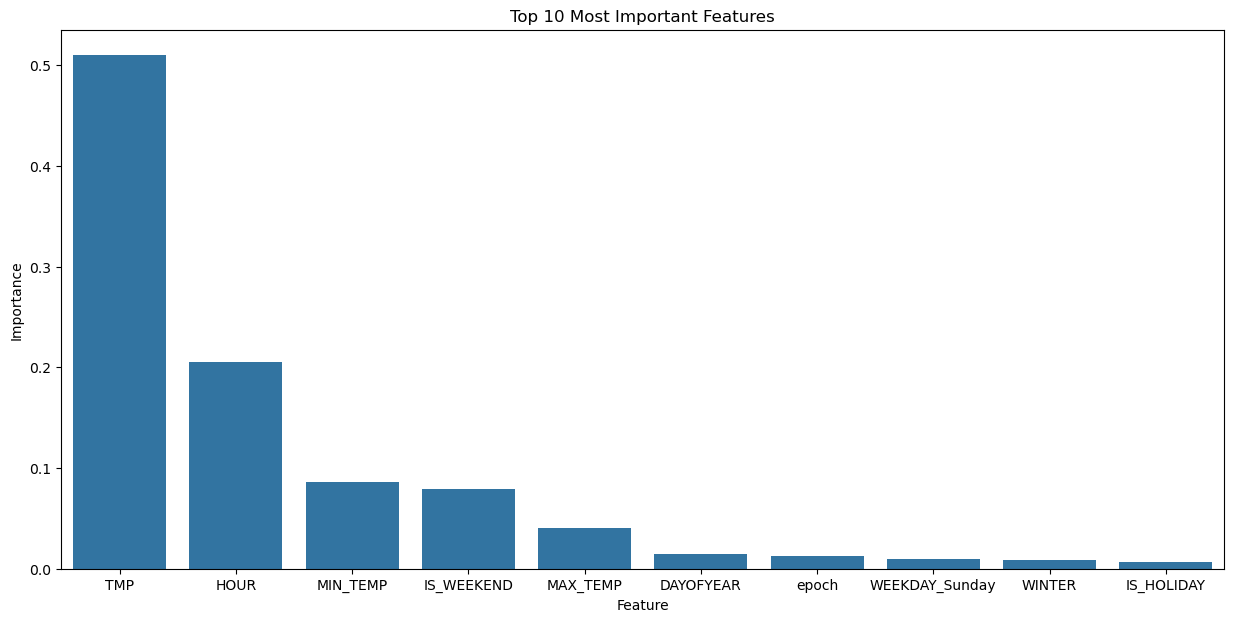

In [13]:
df_feat = pd.DataFrame({'Feature': X_train.columns, 'Importance': gbr_final.feature_importances_})
df_feat.sort_values(by='Importance', inplace=True, ascending=False)
df_feat = df_feat.iloc[:10]

plt.figure(figsize=(15,7))
sns.barplot(df_feat, y='Importance', x='Feature')
plt.title('Top 10 Most Important Features')

Text(0.5, 1.0, 'Gradient Boosting Regression - Residuals vs Predicted')

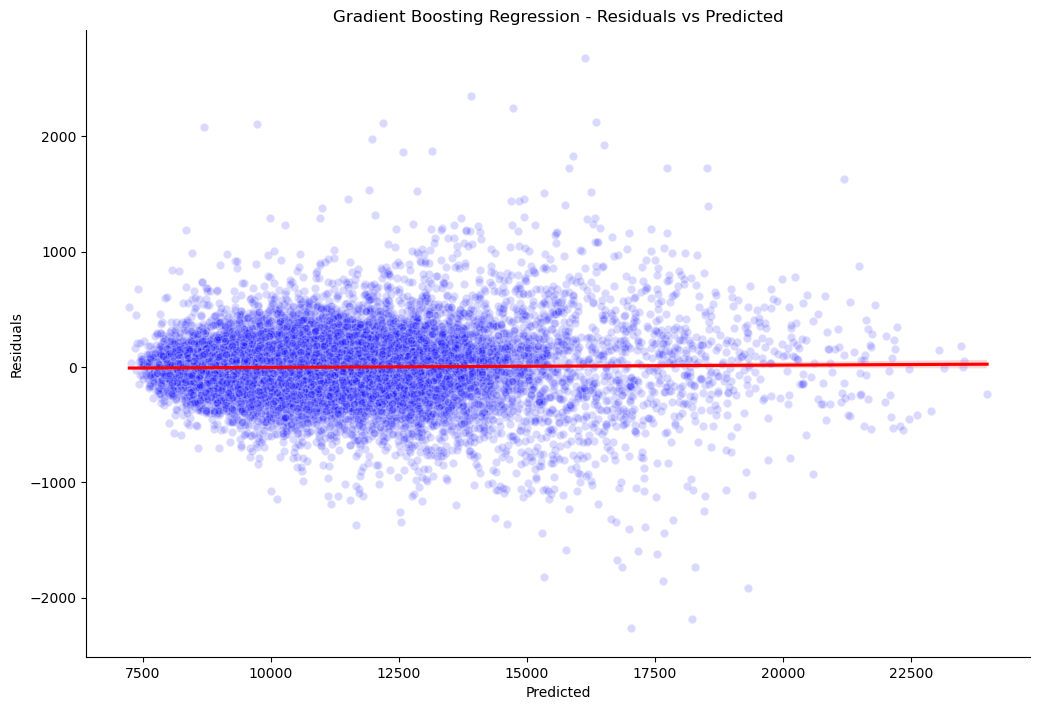

In [14]:
df_gbr_results = pd.DataFrame({'Actual': y_test, 'Predicted': gbr_cv_pred})
df_gbr_results['Residuals'] = df_gbr_results['Actual'] - df_gbr_results['Predicted']

sns.lmplot(x='Predicted', y='Residuals', data=df_gbr_results, height=7,
          aspect=1.5, scatter_kws={'alpha': 0.15, 'color': 'blue', 'edgecolor': 'white'},
          line_kws={'color': 'red'})
plt.title('Gradient Boosting Regression - Residuals vs Predicted')